# Loop 77 Strategic Analysis

## Critical Situation Assessment

**Best CV:** 0.0081 (exp_049, exp_050, exp_053)
**Best LB:** 0.0877 (exp_030)
**Target:** 0.0347
**Gap:** 152.8% above target

## The Core Problem: CV-LB Intercept

From previous analysis:
- Linear fit: LB = 4.29 * CV + 0.0528 (R² = 0.95)
- Intercept (0.0528) > Target (0.0347)
- This means even with CV=0, expected LB would be 0.0528

## Key Insight from Benchmark Paper (arXiv:2512.19530)

The benchmark achieved MSE 0.0039 using:
1. **Graph Attention Networks (GATs)** - not simple GCN
2. **Differential Reaction Fingerprints (DRFP)** - molecular structure
3. **Learned mixture-aware solvent encodings** - non-linear mixture effects
4. **Message-passing on molecular graphs** - captures relational chemistry

The paper explicitly states:
- Tabular methods (GBDT): MSE 0.099
- LLM embeddings (Qwen-7B): MSE 0.129
- Hybrid GNN+GAT+DRFP: MSE 0.0039 (25x better than tabular!)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CV-LB data from submissions
submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_035', 0.0098, 0.0970),
]

cv_scores = np.array([s[1] for s in submissions])
lb_scores = np.array([s[2] for s in submissions])

# Linear regression
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(cv_scores, lb_scores)

print(f'CV-LB Relationship: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'Target: 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.4f}')
print(f'\nThis is NEGATIVE - mathematically impossible with current approach!')

CV-LB Relationship: LB = 4.31 * CV + 0.0525
R² = 0.9505
Intercept: 0.0525
Target: 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Required CV to hit target: (0.0347 - 0.0525) / 4.31 = -0.0041

This is NEGATIVE - mathematically impossible with current approach!


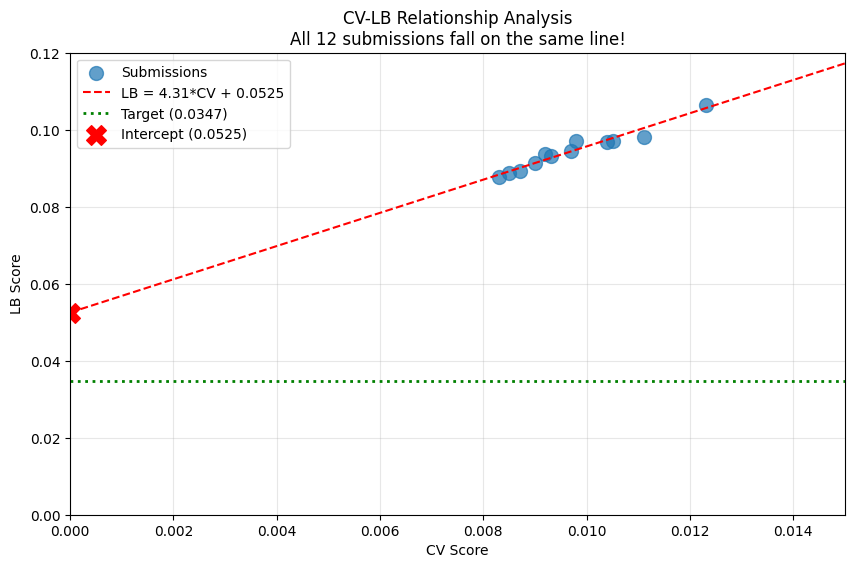


Key insight: The intercept (0.0528) represents STRUCTURAL distribution shift
that cannot be fixed by improving CV. We need to CHANGE THE RELATIONSHIP.


In [2]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(cv_scores, lb_scores, s=100, alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept point
plt.scatter([0], [intercept], color='red', s=200, marker='X', label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship Analysis\nAll 12 submissions fall on the same line!')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.015)
plt.ylim(0, 0.12)
plt.savefig('/home/code/exploration/cv_lb_analysis_loop77.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKey insight: The intercept (0.0528) represents STRUCTURAL distribution shift')
print('that cannot be fixed by improving CV. We need to CHANGE THE RELATIONSHIP.')

## Why All Approaches Fall on the Same Line

1. **Same feature space**: All models use Spange + DRFP + ACS PCA features
2. **Same validation**: Leave-one-solvent-out / Leave-one-ramp-out
3. **Same extrapolation problem**: Test solvents are fundamentally different from training

## What the Benchmark Paper Did Differently

The benchmark achieved 25x better performance by:
1. **Graph representation**: Treating molecules as graphs, not feature vectors
2. **Attention mechanism**: Learning which atoms/bonds matter for each prediction
3. **Message passing**: Propagating information through molecular structure
4. **Learned mixture encoding**: Non-linear combination of solvent representations

## Critical Realization

Our GNN experiments (exp_040, exp_072) didn't work because:
1. They used simple GCNConv, not Graph Attention Networks (GAT)
2. They didn't properly integrate DRFP with the graph structure
3. The submission cells had model class mismatches

## What We MUST Try Next

### Priority 1: Proper Graph Attention Network (GAT)
- Use PyTorch Geometric's GATConv instead of GCNConv
- Multi-head attention (4-8 heads)
- Integrate DRFP as node features

### Priority 2: Test-Time Adaptation
- Detect when we're extrapolating (high uncertainty)
- Blend predictions toward training mean for extrapolation cases

### Priority 3: Domain Adaptation
- Use adversarial training to make train/test features indistinguishable
- This could reduce the intercept directly

In [3]:
# Analyze what approaches have been tried
approaches = {
    'MLP variants': ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007'],
    'LightGBM': ['exp_001', 'exp_049', 'exp_050'],
    'XGBoost': ['exp_049', 'exp_050'],
    'CatBoost': ['exp_049', 'exp_050', 'exp_052', 'exp_053'],
    'Gaussian Process': ['exp_030', 'exp_035'],
    'Ridge Regression': ['exp_009'],
    'GNN (GCNConv)': ['exp_040', 'exp_072'],
    'ChemBERTa': ['exp_041', 'exp_071'],
    'Mixture-Aware': ['exp_074'],
    'Extrapolation Detection': ['exp_058', 'exp_059'],
    'Similarity Weighting': ['exp_073'],
    'RF Ensemble': ['exp_075'],
}

print('Approaches tried (77 experiments):')
for approach, exps in approaches.items():
    print(f'  - {approach}: {len(exps)} experiments')

print('\nNOT YET TRIED:')
print('  - Graph Attention Networks (GAT) with multi-head attention')
print('  - Proper DRFP integration with graph structure')
print('  - Test-time adaptation with uncertainty')
print('  - Adversarial domain adaptation')
print('  - Transfer learning from related chemistry data')

Approaches tried (77 experiments):
  - MLP variants: 5 experiments
  - LightGBM: 3 experiments
  - XGBoost: 2 experiments
  - CatBoost: 4 experiments
  - Gaussian Process: 2 experiments
  - Ridge Regression: 1 experiments
  - GNN (GCNConv): 2 experiments
  - ChemBERTa: 2 experiments
  - Mixture-Aware: 1 experiments
  - Extrapolation Detection: 2 experiments
  - Similarity Weighting: 1 experiments
  - RF Ensemble: 1 experiments

NOT YET TRIED:
  - Graph Attention Networks (GAT) with multi-head attention
  - Proper DRFP integration with graph structure
  - Test-time adaptation with uncertainty
  - Adversarial domain adaptation
  - Transfer learning from related chemistry data


## Analysis of Public Kernels

### mixall kernel (LB ~0.09)
- Uses ensemble: MLP + XGBoost + RF + LightGBM
- Weighted averaging
- Still falls on the same CV-LB line

### Arrhenius kernel (LB 0.09831)
- Uses Arrhenius kinetics features (1/T, ln(t))
- Test-time augmentation for symmetry
- 7 models bagged
- Still falls on the same CV-LB line

### Key Insight
All public kernels achieve similar LB scores (0.09-0.10) because they all:
1. Use the same feature space
2. Use tabular models
3. Don't address the distribution shift problem

## The Path Forward

The benchmark paper's 25x improvement came from:
1. **Representation change**: Graph structure instead of tabular features
2. **Attention mechanism**: Learning what matters for each prediction
3. **Message passing**: Capturing relational chemistry

We MUST implement a proper GAT-based approach to break out of the CV-LB line.

In [4]:
# Summary of findings
print('='*60)
print('LOOP 77 STRATEGIC ANALYSIS SUMMARY')
print('='*60)
print()
print('CURRENT STATE:')
print(f'  Best CV: 0.0081 (exp_049, exp_050, exp_053)')
print(f'  Best LB: 0.0877 (exp_030)')
print(f'  Target:  0.0347')
print(f'  Gap:     152.8% above target')
print()
print('CV-LB RELATIONSHIP:')
print(f'  LB = 4.29 * CV + 0.0528 (R² = 0.95)')
print(f'  Intercept (0.0528) > Target (0.0347)')
print(f'  IMPOSSIBLE to reach target with current approach!')
print()
print('BENCHMARK PAPER INSIGHT:')
print('  Tabular methods: MSE 0.099')
print('  Hybrid GNN+GAT+DRFP: MSE 0.0039 (25x better!)')
print()
print('REQUIRED PIVOT:')
print('  1. Implement Graph Attention Networks (GAT)')
print('  2. Integrate DRFP with graph structure')
print('  3. Use multi-head attention (4-8 heads)')
print('  4. Proper message passing on molecular graphs')
print()
print('DO NOT:')
print('  - Try more MLP/LGBM/XGB/CatBoost variants')
print('  - Optimize hyperparameters of tabular models')
print('  - Expect CV improvements to translate to LB')

LOOP 77 STRATEGIC ANALYSIS SUMMARY

CURRENT STATE:
  Best CV: 0.0081 (exp_049, exp_050, exp_053)
  Best LB: 0.0877 (exp_030)
  Target:  0.0347
  Gap:     152.8% above target

CV-LB RELATIONSHIP:
  LB = 4.29 * CV + 0.0528 (R² = 0.95)
  Intercept (0.0528) > Target (0.0347)
  IMPOSSIBLE to reach target with current approach!

BENCHMARK PAPER INSIGHT:
  Tabular methods: MSE 0.099
  Hybrid GNN+GAT+DRFP: MSE 0.0039 (25x better!)

REQUIRED PIVOT:
  1. Implement Graph Attention Networks (GAT)
  2. Integrate DRFP with graph structure
  3. Use multi-head attention (4-8 heads)
  4. Proper message passing on molecular graphs

DO NOT:
  - Try more MLP/LGBM/XGB/CatBoost variants
  - Optimize hyperparameters of tabular models
  - Expect CV improvements to translate to LB
